In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
#################################### 한글깨짐 ####################################
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")
##################################################################################

In [114]:
train = pd.read_csv("../bike-sharing-demand/train.csv", parse_dates=["datetime"])
test = pd.read_csv("../bike-sharing-demand/test.csv", parse_dates=["datetime"])

In [115]:
# datetime컬럼 정리
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek

In [116]:
# fig, axes = plt.subplots(nrows=2)
# fig.set_size_inches(18,10)
# sns.countplot(data=train, x = 'windspeed', ax=axes[0])
# sns.countplot(data=train, x = 'windspeed', hue='season', ax=axes[1])

In [117]:
# def badToRight(month):
#     if month in [12,1,2]:
#         return 4
#     elif month in [3,4,5]:
#         return 1
#     elif month in [6,7,8]:
#         return 2
#     elif month in [9,10,11]:
#         return 3

# #apply() 내장함수는 split(),map(),join(),filter()등 과 함꼐 필수적으로 숙지해야 할 함수이다.
# train['season'] = train.month.apply(badToRight)
# test['season'] = test.month.apply(badToRight)

In [118]:
# 컬럼 카테고리화
fn = ['season','holiday','workingday','weather','dayofweek','month','year','hour']
for var in fn:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [119]:
# 트레인 / 테스트데이터셋 정리
fns = ['season','holiday','workingday','weather','temp','atemp', 'humidity', 'windspeed','year', 'month', 'hour', 'dayofweek']
xTrain = train[fns]
xTest = test[fns]
yTrain = train['count']

In [120]:
# rmse 평가
from sklearn.metrics import make_scorer
def rmsle(predicted_values, actual_values, convertExp=True):
    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    # 평균을 낸다.
    mean_difference = difference.mean()
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    return score

In [121]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
# 선형회귀 모델을 초기화
lModel = LinearRegression()
# 모델을 학습시킨다.
yTrain_log = np.log1p(yTrain)
lModel.fit(xTrain, yTrain_log)
# 예측하고 정확도를 평가한다.
preds = lModel.predict(xTrain)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(yTrain_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9778188829547169


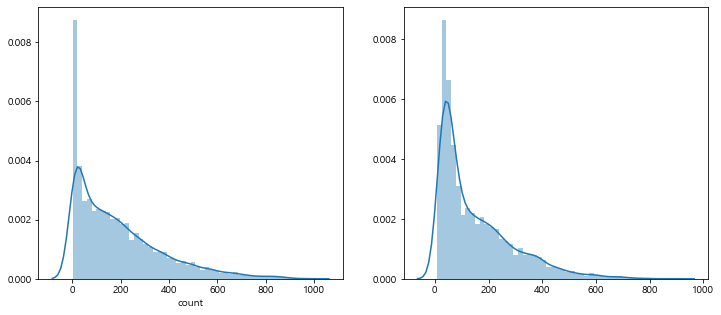

In [122]:
# 선형회귀 정확도 비교
predsTest = lModel.predict(xTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(yTrain,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [123]:
# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01)

yTrain_log = np.log1p(yTrain)
gbm.fit(xTrain, yTrain_log)

preds = gbm.predict(xTrain)
score = rmsle(np.exp(yTrain_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.19449279580975506


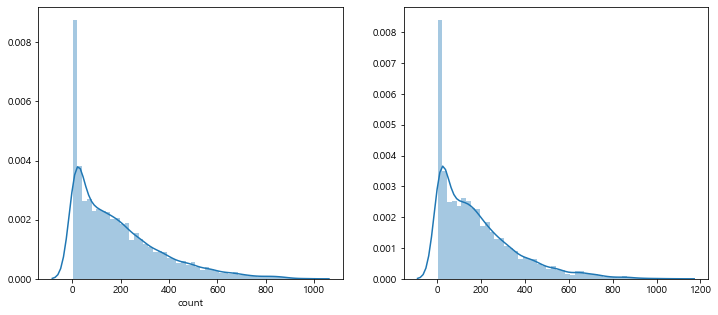

In [124]:
predsTest = gbm.predict(xTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(yTrain,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [125]:
submission = pd.read_csv("../bike-sharing-demand/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,10.482740
1,2011-01-20 01:00:00,5.512273
2,2011-01-20 02:00:00,3.733124
3,2011-01-20 03:00:00,2.801715
4,2011-01-20 04:00:00,2.427238


In [126]:
submission.to_csv("submission2.csv", index=False)